In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import OUT_MODEL_DIR
from utils.load import load_data, save_file, get_model_dict, get_model_list, get_metrics_overview
from src.dm import dm_test
from src.src import ModelMetrics

In [5]:
model_list = []

for item in get_model_list(OUT_MODEL_DIR):
    model_list.append(ModelMetrics(get_model_dict(os.path.join(OUT_MODEL_DIR, item))))
df_f, df = get_metrics_overview(model_list)

2022-04-30_arma_daily_FF_TS_VX_years2021_2012_sp_close_lead1_data_dict.pkl
2022-05-02_lgb_daily_FF_TS_VX_years2021_2012_sp_close_lead1_data_dict.pkl
2022-05-02_ols_daily_FF_TS_VX_years2021_2012_sp_close_lead1_data_dict.pkl
2022-05-01_rw_daily_FF_TS_VX_years2021_2012_sp_close_lead1_data_dict.pkl


In [6]:
df.to_excel(os.path.join(OUT_MODEL_DIR, "rmse.xlsx"))
df

,model_type,predicted,variables,tinterval,year_spread,rmse,mse,mae,r2
0,arma,sp_close_lead1,FF_TS_VX,daily,years2021_2012,0.008735,0.000076,0.006351,-0.044674
1,lgb,sp_close_lead1,FF_TS_VX,daily,years2021_2012,0.00979,0.000096,0.007397,-0.312267
2,ols,sp_close_lead1,FF_TS_VX,daily,years2021_2012,0.008571,0.000073,0.006366,-0.005825
3,rw,sp_close_lead1,FF_TS_VX,daily,years2021_2012,0.008592,0.000074,0.006355,-0.010836


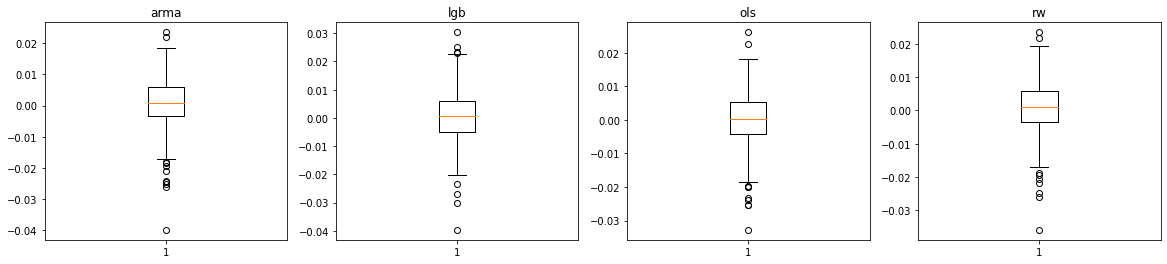

In [7]:
fig, ax = plt.subplots(ncols=len(model_list), nrows=1, figsize=(len(model_list) * 5, 4))

_df = df_f[[item for item in df_f.columns if "resid" in item]].copy()
for i, item in enumerate(model_list):
    # ax[i].set_ylim([-0.06, 0.06])
    ax[i].boxplot(_df.iloc[:, i].dropna())
    ax[i].set_title(item.model_type)


In [8]:
# DM test
list_name1 = []
list_name2 = []
list_pvalue = []
list_stat = []
is_sig = []

sig = .05 / 6

df_f.dropna(inplace=True)
_df = df_f[[item for item in df_f.columns if 'y_pred' in item]].copy()

for item1 in _df.iteritems():
    for item2 in _df.iteritems():  
        if item1[1].name == item2[1].name:
            break
        else:
            test = dm_test(df_f.y_test, item1[1], item2[1])
            list_name1.append(item1[1].name)
            list_name2.append(item2[1].name)
            list_pvalue.append(test.p_value)
            list_stat.append(test.DM)
            is_sig.append(test.p_value < sig)

In [9]:
x = pd.DataFrame(data=[list_name1, list_name2, list_pvalue, list_stat]).transpose()
x.columns = ['name1', 'name2', 'pvalue', 'stat']
dm_res = x.pivot_table(values=['pvalue', 'stat'], index='name1', columns=['name2'])
dm_res.columns = [item[1] for item in dm_res.columns]

dm_res.to_excel(os.path.join(OUT_MODEL_DIR, 'dm_test.xlsx'))

In [10]:
dm_res

,arma_y_pred,lgb_y_pred,ols_y_pred,arma_y_pred,lgb_y_pred,ols_y_pred
name1,,,,,,
lgb_y_pred,0.000699,NaN,NaN,3.435285,NaN,NaN
ols_y_pred,0.475098,0.000043,NaN,-0.715353,-4.171616,NaN
rw_y_pred,0.358676,0.000016,0.886666,-0.919685,-4.407096,0.142678


In [11]:
# plot

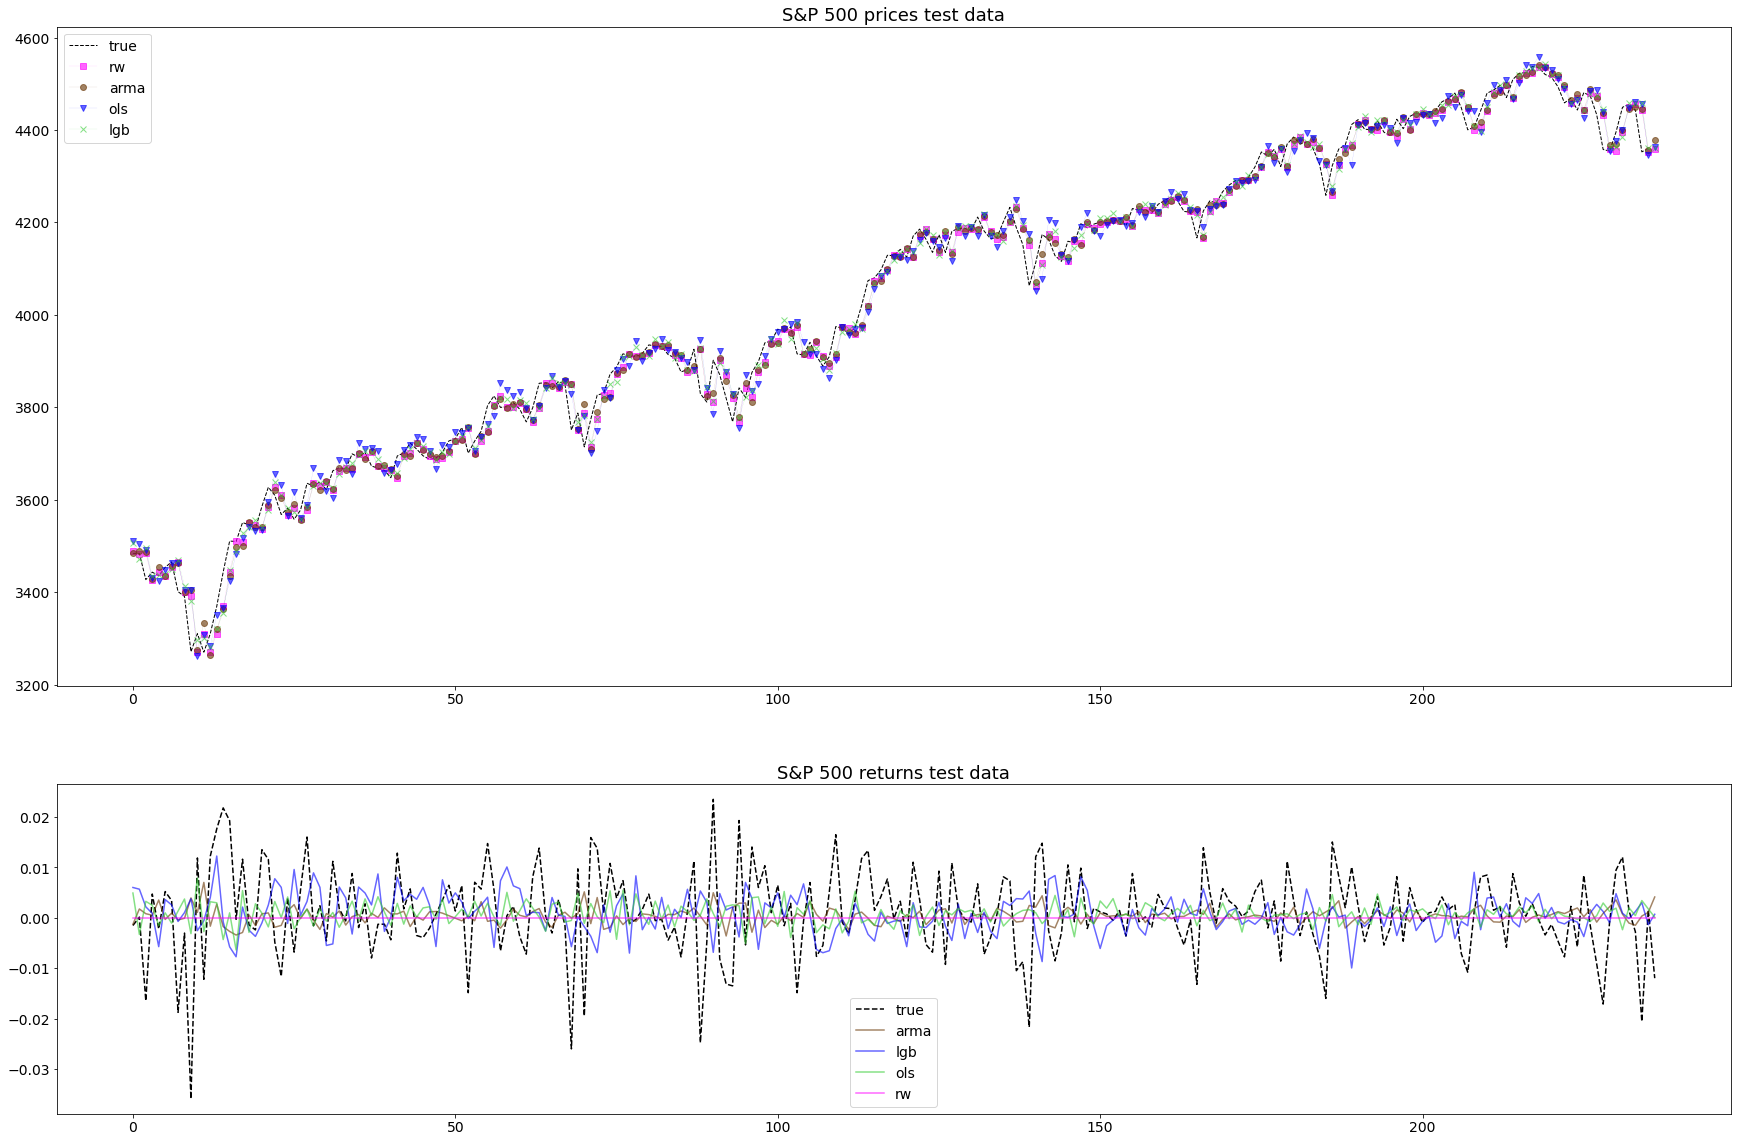

In [12]:
alpha = .6

plt.rcParams['font.size'] = '14'
fig, ax = plt.subplots(2, 1, figsize=(30, 20), gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(df_f.y_prices.shift(-1),'--', color='black', lw=1)
ax[0].plot(df_f.y_prices + df_f.rw_y_pred * df_f.y_prices, color='#ff00ff', lw=.1, marker="s", alpha=alpha)
ax[0].plot(df_f.y_prices + df_f.arma_y_pred * df_f.y_prices, color='#663300', lw=.1, marker='o', alpha=alpha)
ax[0].plot(df_f.y_prices + df_f.lgb_y_pred * df_f.y_prices, color='#0000ff', lw=.1, marker="v", alpha=alpha)
ax[0].plot(df_f.y_prices + df_f.ols_y_pred * df_f.y_prices, color='#33cc33', lw=.1, marker="x", alpha=alpha)

ax[0].legend(['true', 'rw', 'arma', 'ols', 'lgb'])
ax[0].set_title('S&P 500 prices test data', fontdict={'fontsize': 18, 'fontweight': 'medium'})

ax[1].plot(df_f.y_test, '--', color='black')
ax[1].plot(df_f.arma_y_pred, color='#663300', alpha=alpha)
ax[1].plot(df_f.lgb_y_pred, color='#0000ff', alpha=alpha)
ax[1].plot(df_f.ols_y_pred, color='#33cc33', alpha=alpha)
ax[1].plot(df_f.rw_y_pred, color='#ff00ff', alpha=alpha)
ax[1].legend(['true', 'arma', 'lgb', 'ols', 'rw'])
ax[1].set_title('S&P 500 returns test data', fontdict={'fontsize': 18, 'fontweight': 'medium'})

# plt.tight_layout(pad=.5)

fig.savefig(os.path.join(OUT_MODEL_DIR, "price_fig.png"))